# Generate figures
This notebook will generate all main and supplemental figures that are not already generated by notebook 4.

In [1]:
import os
import sys
import pickle

import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
from scipy import stats
import logomaker
from pybedtools import BedTool
from IPython.display import display

sys.path.insert(0, "utils")
from utils import fasta_seq_parse_manip, gkmsvm, modeling, plot_utils, predicted_occupancy, sequence_annotation_processing

data_dir = os.path.join("Data")
seq_bins_dir = os.path.join(data_dir, "ActivityBins")
models_dir = os.path.join("Models", "StrongEnhancerVsSilencer")
figures_dir = os.path.join("Figures")
all_seqs = fasta_seq_parse_manip.read_fasta(os.path.join(data_dir, "library1And2.fasta"))
# Drop scrambled sequences
all_seqs = all_seqs[~(all_seqs.index.str.contains("scr"))]

In [2]:
plot_utils.set_manuscript_params()

## Load in all the data

In [3]:
# Mapping activity class to a color
color_mapping = {
    "Silencer": "#e31a1c",
    "Inactive": "#33a02c",
    "Weak enhancer": "#a6cee3",
    "Strong enhancer": "#1f78b4",
    np.nan: "grey"
}
color_mapping = pd.Series(color_mapping)

# Sort order for the four activity bins
class_sort_order = ["Silencer", "Inactive", "Weak enhancer", "Strong enhancer"]

# MPRA measurements
activity_df = pd.read_csv(os.path.join(data_dir, "wildtypeMutantPolylinkerActivityAnnotated.txt"), sep="\t", index_col=0)
activity_df["group_name_WT"] = sequence_annotation_processing.to_categorical(activity_df["group_name_WT"])
activity_df["group_name_MUT"] = sequence_annotation_processing.to_categorical(activity_df["group_name_MUT"])

# TF occupancy metrics, also separate out the WT sequences
occupancy_df = pd.read_csv(os.path.join(data_dir, "predictedOccupancies.txt"), sep="\t", index_col=0)
wt_occupancy_df = occupancy_df[occupancy_df.index.str.contains("WT$")].copy()
wt_occupancy_df = sequence_annotation_processing.remove_mutations_from_seq_id(wt_occupancy_df)
wt_occupancy_df = wt_occupancy_df.loc[activity_df.index]
n_tfs = len(wt_occupancy_df.columns)

# Entropy and related metrics, also separate out WT and MUT
entropy_df = pd.read_csv(os.path.join(data_dir, "entropyDiversityOccupancy.txt"), sep="\t", index_col=0)
wt_entropy_df = entropy_df[entropy_df.index.str.contains("WT$")].copy()
wt_entropy_df = sequence_annotation_processing.remove_mutations_from_seq_id(wt_entropy_df)
wt_entropy_df = wt_entropy_df.loc[activity_df.index]

mut_entropy_df = entropy_df[entropy_df.index.str.contains("MUT")].copy()
mut_entropy_df = sequence_annotation_processing.remove_mutations_from_seq_id(mut_entropy_df)
mut_entropy_df = mut_entropy_df.loc[activity_df.index]

# Occupancy logistic regression (need this to sort by feature importance)
occ_clf = pickle.load(open(os.path.join(models_dir, "logit_model.pkl"), "rb"))

# Axis ticks for Rho assay
rho_ticks = np.arange(-10, 7, 2)

# xaxis for ROC/PR curves
modeling_xaxis = np.linspace(0, 1, 100)

# Model performance metrics with a helper function
def read_metrics(filename, input_dir=models_dir):
    return pd.read_csv(os.path.join(input_dir, filename), sep="\t", header=None)

# Cross-validated metrics
svm_tpr_cv = read_metrics("svmTprCv.txt")
svm_prec_cv = read_metrics("svmPrecCv.txt")
crx_occ_tpr_cv = read_metrics("crxTprCv.txt")
crx_occ_prec_cv = read_metrics("crxPrecCv.txt")
entropy_tpr_cv = read_metrics("entropyTprCv.txt")
entropy_prec_cv = read_metrics("entropyPrecCv.txt")
occ_tpr_cv = read_metrics("occupancyTprCv.txt")
occ_prec_cv = read_metrics("occupancyPrecCv.txt")

# White 2013 test set
white_svm_tpr = read_metrics("whiteSvmTpr.txt").squeeze()
white_svm_prec = read_metrics("whiteSvmPrec.txt").squeeze()
white_occ_tpr = read_metrics("whiteOccTpr.txt").squeeze()
white_occ_prec = read_metrics("whiteOccPrec.txt").squeeze()

# Random PWMs background
random_occ_tprs = read_metrics("randomFeaturesMeanTprs.txt")
random_occ_precs = read_metrics("randomFeaturesMeanPrecs.txt")

# Strong enhancer vs. inactive for info content
inactive_entropy_tpr_cv = read_metrics("entropyTprCv.txt", input_dir=os.path.join("Models", "StrongEnhancerVsInactive"))
inactive_entropy_prec_cv = read_metrics("entropyPrecCv.txt", input_dir=os.path.join("Models", "StrongEnhancerVsInactive"))

# PWMs
pwms = predicted_occupancy.read_pwm_files(os.path.join("Data", "Downloaded", "Pwm", "photoreceptorAndEnrichedMotifs.meme"))
pwms = pwms.rename(lambda x: x.split("_")[0])
motif_len = pwms.apply(len)
mu = 9
ewms = pwms.apply(predicted_occupancy.ewm_from_letter_prob).apply(predicted_occupancy.ewm_to_dict)

# Reverse compliment RAX for display purposes
rax = pwms["RAX"].copy()
rax = rax[::-1].reset_index(drop=True)
rax_rc = rax.copy()
rax_rc["A"] = rax["T"]
rax_rc["C"] = rax["G"]
rax_rc["G"] = rax["C"]
rax_rc["T"] = rax["A"]
pwms["RAX"] = rax_rc

## Figure 1: Activity of putative cis-regulatory sequences with CRX motifs.

In [4]:
# Can only plot points that were detected in DNA
activity_measured_wt_df = activity_df[activity_df["expression_log2_WT"].notna()]
print("Frequency of each activity bin in WT sequences:")
display(activity_measured_wt_df["group_name_WT"].value_counts(normalize=True, dropna=False, sort=False))

# Count frequency of activity bins for CRX bound/unbound
crx_bound_grouper = activity_df.groupby("crx_bound")
chip_activity_bin_freqs = crx_bound_grouper["group_name_WT"].value_counts().unstack()
chip_activity_bin_freqs = chip_activity_bin_freqs[class_sort_order].rename(index=lambda x: "ChIP-seq" if x else "ATAC-seq")

# Different ways to format group names
chip_group_names_with_n = [f"{i}\nn={j.sum()}" for i, j in chip_activity_bin_freqs.iterrows()]
chip_group_names_with_n_oneline = [" ".join(i.split()) for i in chip_group_names_with_n]
chip_group_names = chip_activity_bin_freqs.index.values
chip_group_count = [j.sum() for i, j in chip_activity_bin_freqs.iterrows()]

# Display the data behind Fig 1b
print("Frequency of activity bins vs. CRX binding status:")
display(chip_activity_bin_freqs)

# Test if CRX binding and inactive status is independent
chip_group_inactive_counts = crx_bound_grouper["group_name_WT"].apply(lambda x: (x == "Inactive").value_counts()).unstack()
oddsratio, pval = stats.fisher_exact(chip_group_inactive_counts)
# Take inverse of odds ratio to match language of manuscript and be more intuitive to the reader
print(f"ChIP-seq status is independent of if a sequence is inactive, Fisher's exact test p={pval:.0e}, odds ratio={1/oddsratio:.2f}")

# Same for strong enhancer
chip_group_inactive_counts = crx_bound_grouper["group_name_WT"].apply(lambda x: (x == "Strong enhancer").value_counts()).unstack()
oddsratio, pval = stats.fisher_exact(chip_group_inactive_counts)
# Take inverse of odds ratio to match language of manuscript and be more intuitive to the reader
print(f"ChIP-seq status is independent of if a sequence is inactive, Fisher's exact test p={pval:.0e}, odds ratio={oddsratio:.2f}")

# Row-normalize the counts
chip_activity_bin_freqs = chip_activity_bin_freqs.div(chip_activity_bin_freqs.sum(axis=1), axis=0)
display(chip_activity_bin_freqs)

# Setup for some downstream stuff
wt_activity_grouper = activity_df.groupby("group_name_WT")
wt_activity_names_oneline = ["Silencer", "Inactive", "Weak enh.", "Strong enh."]
wt_activity_count = [len(j) for i, j in wt_activity_grouper]

# Predicted CRX occupancy vs. WT group
wt_occupancy_grouper = wt_occupancy_df.groupby(activity_df["group_name_WT"])
wt_occupancy_grouper_crx = wt_occupancy_grouper["CRX"]
print("Predicted CRX occupancies:")
display(wt_occupancy_grouper_crx.describe())

# Statistics for differences in CRX occupancy between groups
ustat, pval = stats.mannwhitneyu(wt_occupancy_grouper_crx.get_group("Strong enhancer"), wt_occupancy_grouper_crx.get_group("Inactive"), alternative="two-sided")
print(f"Strong enhancers and inactive sequences have the same CRX occupancy, Mann-Whitney U test p = {pval:.0e} U = {ustat:.2f}")
ustat, pval = stats.mannwhitneyu(wt_occupancy_grouper_crx.get_group("Silencer"), wt_occupancy_grouper_crx.get_group("Inactive"), alternative="two-sided")
print(f"Silencers and inactive sequences have the same CRX occupancy, Mann-Whitney U test p = {pval:.0e}, U = {ustat:.2f}")

Frequency of each activity bin in WT sequences:


Silencer           0.173615
Inactive           0.192491
Weak enhancer      0.282099
Strong enhancer    0.218005
NaN                0.133790
Name: group_name_WT, dtype: float64

Frequency of activity bins vs. CRX binding status:


group_name_WT,Silencer,Inactive,Weak enhancer,Strong enhancer
crx_bound,,,,
ATAC-seq,281,363,430,211
ChIP-seq,556,565,930,840


ChIP-seq status is independent of if a sequence is inactive, Fisher's exact test p=2e-07, odds ratio=1.49
ChIP-seq status is independent of if a sequence is inactive, Fisher's exact test p=1e-21, odds ratio=2.16


group_name_WT,Silencer,Inactive,Weak enhancer,Strong enhancer
crx_bound,,,,
ATAC-seq,0.218677,0.282490,0.334630,0.164202
ChIP-seq,0.192321,0.195434,0.321688,0.290557


Predicted CRX occupancies:


,count,mean,std,min,25%,50%,75%,max
group_name_WT,,,,,,,,
Silencer,837.0,2.822068,1.474613,0.013521,1.598510,2.724195,3.916786,8.028408
Inactive,928.0,2.232489,1.342345,0.001052,1.173444,2.048457,3.136282,6.759976
Weak enhancer,1360.0,2.216861,1.220496,0.000385,1.235126,2.113810,2.988673,7.801177
Strong enhancer,1051.0,2.534010,1.169460,0.003694,1.616414,2.490314,3.285321,7.368500


Strong enhancers and inactive sequences have the same CRX occupancy, Mann-Whitney U test p = 6e-10 U = 566045.00
Silencers and inactive sequences have the same CRX occupancy, Mann-Whitney U test p = 6e-17, U = 477843.00


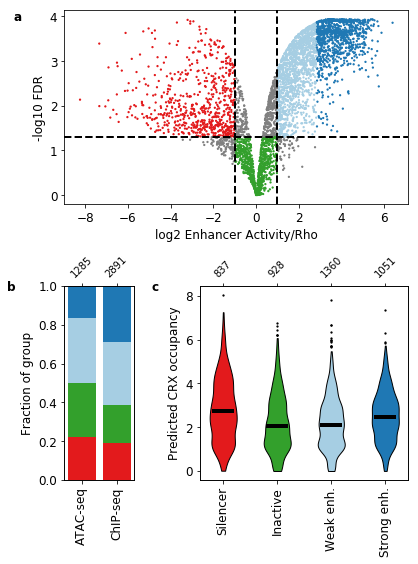

In [5]:
# Setup the figure
gs_kw = dict(width_ratios=[1, 3])
fig, ax_list = plt.subplots(nrows=2, ncols=2, figsize=(6, 8), gridspec_kw=gs_kw)
gs = ax_list[0, 0].get_gridspec()
for ax in ax_list[0, :]:
    ax.remove()
    
axbig = fig.add_subplot(gs[0, :])
ax = axbig

# 1a: Volcano plot
fig = plot_utils.volcano_plot(activity_measured_wt_df, "expression_log2_WT", "expression_qvalue_WT",
                             activity_measured_wt_df["plot_color_WT"], xaxis_label="log2 Enhancer Activity/Rho",
                             yaxis_label="-log10 FDR", xline=-np.log10(0.05), yline=[-1, 1],
                             xticks=rho_ticks[1:], figax=(fig, ax))
ax.set_yticks(np.arange(5))
plot_utils.add_letter(ax, -0.125, 1, "a")

# 1b: CRX binding status vs. activity classes
ax = ax_list[1, 0]
fig = plot_utils.stacked_bar_plots(chip_activity_bin_freqs, "Fraction of group", chip_group_names, color_mapping, figax=(fig, ax), vert=True)
ax.set_yticks(np.linspace(0, 1, 6))
plot_utils.rotate_ticks(ax.get_xticklabels())    

# Add ticks above to show the n
ax_twin = ax.twiny()
ax_twin.set_xticks(ax.get_xticks())
ax_twin.set_xlim(ax.get_xlim())
ax_twin.set_xticklabels(chip_group_count, fontsize=10, rotation=45)
plot_utils.add_letter(ax, -0.7, 1.03, "b")

# 1c: Predicted CRX occupancy of different groups
ax = ax_list[1, 1]
fig = plot_utils.violin_plot_groupby(wt_occupancy_grouper_crx, "Predicted CRX occupancy", class_names=wt_activity_names_oneline, class_colors=color_mapping, figax=(fig, ax))
ax.set_yticks(np.linspace(0, 8, 5))
plot_utils.rotate_ticks(ax.get_xticklabels())

# Add ticks above to show the n
ax_twin = ax.twiny()
ax_twin.set_xticks(ax.get_xticks())
ax_twin.set_xlim(ax.get_xlim())
ax_twin.set_xticklabels(wt_activity_count, fontsize=10, rotation=45)
plot_utils.add_letter(ax, -0.2, 1.03, "c")

plot_utils.save_fig(fig, os.path.join(figures_dir, "figure1"), timestamp=False)

## Figure 2: Strong enhancers contain a diverse array of motifs

### Panels a and b
Also Supplemental Figure 3: Precision recall curve for strong enhancer vs. silencer classifiers

Model metrics:
SVM	AUROC=0.781+/-0.013	AUPR=0.812+/-0.020
8 TFs	AUROC=0.698+/-0.036	AUPR=0.745+/-0.032
CRX	AUROC=0.548+/-0.023	AUPR=0.571+/-0.020
Total predicted occupancy of all TFs in each group:


,count,mean,std,min,25%,50%,75%,max
group_name_WT,,,,,,,,
Silencer,837.0,3.588419,1.848387,0.067069,2.167386,3.408131,4.845272,11.848887
Inactive,928.0,3.005903,1.690368,0.034470,1.777625,2.810142,3.968906,12.011682
Weak enhancer,1360.0,3.068334,1.582532,0.010029,1.935493,2.921969,4.031018,12.521734
Strong enhancer,1051.0,3.782727,1.622289,0.021160,2.577761,3.664645,4.762179,10.185356


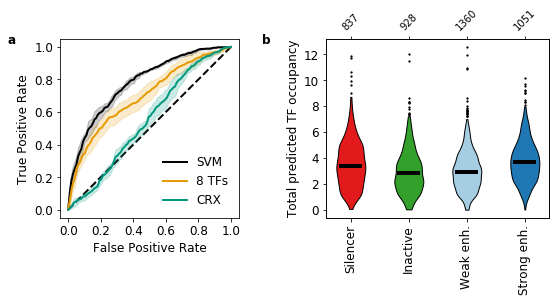

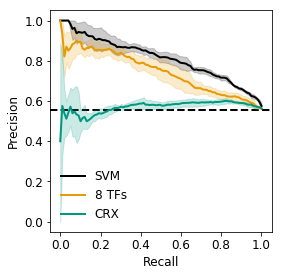

In [6]:
fig, ax_list = plot_utils.setup_multiplot(2, sharex=False, sharey=False)
# Separate figure handle for the PR curves
fig_pr, ax_pr = plt.subplots()

# 2a and supplemental figure 3: ROC and PR curves with SVM, TF occupancies, CRX occupancy
model_data = [ # (TPR, precision, name, color)
    (svm_tpr_cv, svm_prec_cv, "SVM", "black"),
    (occ_tpr_cv, occ_prec_cv, f"{n_tfs} TFs", "#E69B04"),
    (crx_occ_tpr_cv, crx_occ_prec_cv, "CRX", "#009980")
]

model_tprs, model_precs, model_names, model_colors = zip(*model_data)
prc_chance = activity_df["group_name_WT"].str.contains("Strong").sum() / activity_df["group_name_WT"].str.contains("Strong|Silencer").sum()

# Generate figures
_, model_aurocs, model_aurocs_std, model_auprs, model_auprs_std = plot_utils.roc_pr_curves(
    modeling_xaxis, model_tprs, model_precs, model_names, model_colors=model_colors,
    prc_chance=prc_chance, figax=([fig, fig_pr], [ax_list[0], ax_pr])
)
ax_list[0].set_xticks(np.linspace(0, 1, 6))
plot_utils.add_letter(ax_list[0], -0.25, 1.03, "a")

# Display model metrics
print("Model metrics:")
for name, auroc, auroc_std, aupr, aupr_std in zip(model_names, model_aurocs, model_aurocs_std, model_auprs, model_auprs_std):
    print(f"{name}\tAUROC={auroc:.3f}+/-{auroc_std:.3f}\tAUPR={aupr:.3f}+/-{aupr_std:.3f}")

# Calculate total predicted occupancy of each class
wt_entropy_grouper = wt_entropy_df.groupby(activity_df["group_name_WT"])
print("Total predicted occupancy of all TFs in each group:")
display(wt_entropy_grouper["total_occupancy"].describe())

# 2b: Total predicted occupancy of each class
ax = ax_list[1]
fig = plot_utils.violin_plot_groupby(wt_entropy_grouper["total_occupancy"], "Total predicted TF occupancy", class_names=wt_activity_names_oneline, class_colors=color_mapping, figax=(fig, ax))
plot_utils.rotate_ticks(ax.get_xticklabels())
plot_utils.add_letter(ax, -0.25, 1.03, "b")

# Add ticks above to show the n
ax_twin = ax.twiny()
ax_twin.set_xticks(ax.get_xticks())
ax_twin.set_xlim(ax.get_xlim())
ax_twin.set_xticklabels(wt_activity_count, fontsize=10, rotation=45)

plot_utils.save_fig(fig, os.path.join(figures_dir, "figure2ab"), timestamp=False, tight_pad=0)
plot_utils.save_fig(fig_pr, os.path.join(figures_dir, "supplementalFigure3"), timestamp=False)

### Panel c

in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...


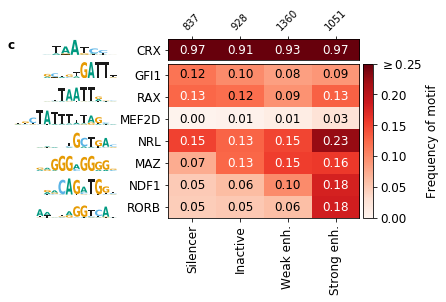

In [7]:
# Calculate motif frequency in each class
occupied_cutoff = 0.5
motif_freq_df = wt_occupancy_grouper.apply(lambda x: (x > occupied_cutoff).sum() / len(x))
# Sort by the feature importance in the logistic model
feature_importance = occ_clf.coef_[0]
feature_order = feature_importance.argsort()
motif_freq_df = motif_freq_df.iloc[:, feature_order]

# Make the fig
fig, ax_list = plt.subplots(nrows=8, ncols=2, figsize=(6, 4), gridspec_kw=dict(width_ratios=[1, 2]))
gs = ax_list[0, 0].get_gridspec()
for ax in ax_list[:, 1]:
    ax.remove()
    
axbig = fig.add_subplot(gs[:, 1])

ax = axbig
vmax = 0.25
thresh = vmax / 2
motif_freq_no_crx_df = motif_freq_df.drop(columns="CRX")
heatmap = ax.imshow(motif_freq_no_crx_df.T, aspect="auto", vmin=0, vmax=vmax, cmap="Reds")
ax.set_xticks(np.arange(len(wt_activity_names_oneline)))
ax.set_xticklabels(wt_activity_names_oneline, rotation=90)
ax.set_yticks(np.arange(len(motif_freq_no_crx_df.columns)))
ax.set_yticklabels(motif_freq_no_crx_df.columns)
plot_utils.annotate_heatmap(ax, motif_freq_no_crx_df, thresh)

# Add the logos
for cax, tf in zip(ax_list[1:, 0], motif_freq_no_crx_df.columns):
    pwm = logomaker.transform_matrix(pwms[tf], from_type="probability", to_type="information")
    logomaker.Logo(pwm, ax=cax, color_scheme="colorblind_safe", show_spines=False)
    # Right-align the logos
    cax.set_xlim(left=motif_len[tf] - motif_len.max() - 0.5)
    cax.set_ylim(top=2)
    cax.set_xticks([])
    cax.set_yticks([])

# Add a colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad="2%")
colorbar = fig.colorbar(heatmap, cax=cax, label="Frequency of motif")
ticks = cax.get_yticks()
ticks = [f"{i:.2f}" for i in ticks]
ticks[-1] = r"$\geq$" + ticks[-1]
cax.set_yticklabels(ticks)

# Add CRX
cax = divider.append_axes("top", size="14%", pad="2%")
heatmap = cax.imshow(motif_freq_df["CRX"].to_frame().T, aspect="auto", vmin=0, vmax=vmax, cmap="Reds")
cax.xaxis.tick_top()
cax.set_xticks(ax.get_xticks())
cax.set_xlim(ax.get_xlim())
cax.set_xticklabels(wt_activity_count, fontsize=10, rotation=45)
cax.set_yticks([0])
cax.set_yticklabels(["CRX"])
plot_utils.annotate_heatmap(cax, motif_freq_df["CRX"].to_frame(), thresh)

# Add CRX logo
cax = ax_list[0, 0]
pwm = logomaker.transform_matrix(pwms["CRX"], from_type="probability", to_type="information")
logomaker.Logo(pwm, ax=cax, color_scheme="colorblind_safe", show_spines=False)
# Right-align the logos
cax.set_xlim(left=motif_len[tf] - motif_len.max() - 0.5)
cax.set_ylim(top=2)
cax.set_xticks([])
cax.set_yticks([])

plot_utils.add_letter(cax, 0, 1.03, "c")
plot_utils.save_fig(fig, os.path.join(figures_dir, "figure2c"), timestamp=False, tight_pad=0)

### Panels d-f

group_name_WT,Silencer,Inactive,Weak enhancer,Strong enhancer
binding_group,,,,
No binding,0.221493,0.286300,0.331419,0.160788
CRX only,0.203553,0.222276,0.346615,0.227556
CRX+NRL,0.192560,0.115974,0.238512,0.452954
CRX+MEF2D,0.145000,0.165000,0.280000,0.410000
All three,0.099338,0.105960,0.284768,0.509934


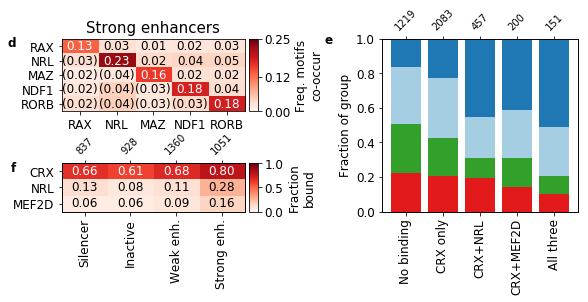

In [8]:
# Setup figure
fig, ax_list = plt.subplots(nrows=2, ncols=2, figsize=(8, 4), gridspec_kw=dict(height_ratios=[3, 2]))
ax2d = ax_list[0, 0]
ax2f = ax_list[1, 0]
for ax in ax_list[:, 1]:
    ax.remove()

ax2e = fig.add_subplot(ax2d.get_gridspec()[:, 1])

# Calculate co-occurrance of motifs in strong enhancers
strong_enh_coocc_df = wt_occupancy_grouper.get_group("Strong enhancer")[["RAX", "NRL", "MAZ", "NDF1", "RORB"]]
strong_enh_coocc_df = (strong_enh_coocc_df > occupied_cutoff).astype(int)
strong_enh_coocc_df = strong_enh_coocc_df.T.dot(strong_enh_coocc_df) / len(strong_enh_coocc_df)
# Fill in lower triangle with the expected values
for row in range(len(strong_enh_coocc_df)):
    for col in range(row + 1, len(strong_enh_coocc_df)):
        strong_enh_coocc_df.iloc[row, col] = strong_enh_coocc_df.iloc[row, row] * strong_enh_coocc_df.iloc[col, col]
        
# 2d: Make the heatmap
ax = ax2d
vmax = 0.25
thresh = vmax / 2
heatmap = ax.imshow(strong_enh_coocc_df, aspect="auto", cmap="Reds", vmax=vmax, vmin=0)
ax.set_title("Strong enhancers")
ax.set_xticks(np.arange(len(strong_enh_coocc_df.columns)))
ax.set_xticklabels(strong_enh_coocc_df.columns)
ax.set_yticks(np.arange(len(strong_enh_coocc_df.columns)))
ax.set_yticklabels(strong_enh_coocc_df.columns)
plot_utils.annotate_heatmap(ax, strong_enh_coocc_df, thresh, adjust_lower_triangle=True)

# Add colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad="2%")
colorbar = fig.colorbar(heatmap, cax=cax, label="Freq. motifs\nco-occur", ticks=[0, round(thresh, 2), vmax])
plot_utils.add_letter(ax, -0.25, 1.03, "d")

# Calculate activity classes for different binding combos
binding_combos_activity_freq = activity_measured_wt_df.groupby("binding_group")["group_name_WT"].value_counts().unstack()
binding_combos_activity_freq = binding_combos_activity_freq[class_sort_order]
# Ignore cases where there is NRL or MEF2D but not CRX
binding_combos_activity_freq = binding_combos_activity_freq.loc[["No binding", "CRX only", "CRX+NRL", "CRX+MEF2D", "All three"]]
binding_combos_activity_freq = binding_combos_activity_freq.astype(int)

# Generate names then normalize data
binding_combos_names = binding_combos_activity_freq.index.values
binding_combos_count = [j.sum() for i, j in binding_combos_activity_freq.iterrows()]
binding_combos_activity_freq = binding_combos_activity_freq.div(binding_combos_activity_freq.sum(axis=1), axis=0)
display(binding_combos_activity_freq)

# 2e: make plot
ax = ax2e
fig = plot_utils.stacked_bar_plots(binding_combos_activity_freq, "Fraction of group", binding_combos_names, color_mapping, figax=(fig, ax), vert=True)
ax.set_yticks(np.linspace(0, 1, 6))
plot_utils.rotate_ticks(ax.get_xticklabels())

# Add the n
ax_twin = ax.twiny()
ax_twin.set_xticks(ax.get_xticks())
ax_twin.set_xlim(ax.get_xlim())
ax_twin.set_xticklabels(binding_combos_count, fontsize=10, rotation=45)
plot_utils.add_letter(ax, -0.25, 1.03, "e")

# Frequency each class is bound by each TF
group_bound_freqs = activity_measured_wt_df.groupby("group_name_WT")[["crx_bound", "nrl_bound", "mef2d_bound"]].apply(lambda x: x.sum() / len(x))
group_bound_freqs.columns = group_bound_freqs.columns.str.split("_").str[0].str.upper()

# 2f: Make heatmakt
vmax = 1
thresh = vmax / 2
ax = ax2f
heatmap = ax.imshow(group_bound_freqs.T, aspect="auto", cmap="Reds", vmax=vmax, vmin=0)
ax.set_xticks(np.arange(len(wt_activity_names_oneline)))
ax.set_xticklabels(wt_activity_names_oneline, rotation=90)
ax.set_yticks(np.arange(len(group_bound_freqs.columns)))
ax.set_yticklabels(group_bound_freqs.columns)
plot_utils.annotate_heatmap(ax, group_bound_freqs, thresh)

# Add colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad="2%")
colorbar = fig.colorbar(heatmap, cax=cax, label="Fraction\nbound")
plot_utils.add_letter(ax, -0.25, 1.03, "f")

# Add ticks above to show the n
ax_twin = ax.twiny()
ax_twin.set_axes_locator(ax.get_axes_locator())
ax_twin.set_xticks(ax.get_xticks())
ax_twin.set_xlim(ax.get_xlim())
ax_twin.set_xticklabels(wt_activity_count, fontsize=10, rotation=45)

plot_utils.save_fig(fig, os.path.join(figures_dir, "figure2def"), timestamp=False, tight_pad=0)

## Supplemental figure 5: Additional validation of the 8 TF predicted occupancy logistic regression model

Model performance on White 2013 test set:
SVM	AUROC = 0.800	AUPR = 0.821
8 TFs	AUROC = 0.662	AUPR = 0.714
AUROCs of random features are normally distributed, KS test p = 0.80, D = 0.06
Probability that the AUROC of the real features is drawn from the background distribution, one-tailed Z-test p = 0.000393
AUPRs of random features are normally distributed, KS test p = 0.81, D = 0.06
Probability that the AUPR of the real features is drawn from the background distribution, one-tailed Z-test p = 0.000796


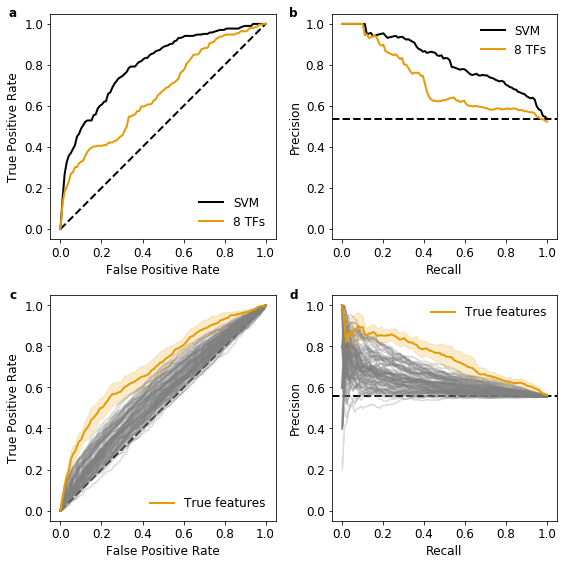

In [10]:
# Setup figure
fig, ax_list = plot_utils.setup_multiplot(4, n_cols=2, sharex=False, sharey=False)
ax_list = ax_list.flatten()

# Plot White 2013 test set
_, white_aurocs, _, white_auprs, _ = plot_utils.roc_pr_curves(
    modeling_xaxis, [white_svm_tpr, white_occ_tpr], [white_svm_prec, white_occ_prec],
    model_names[:2], model_colors=model_colors[:2], prc_chance=white_svm_prec.iloc[-1],
    figax=([fig, fig], ax_list[:2])
)

plot_utils.add_letter(ax_list[0], -0.15, 1.03, "a")
plot_utils.add_letter(ax_list[1], -0.15, 1.03, "b")

# Display model performance
print("Model performance on White 2013 test set:")
print(f"{model_names[0]}\tAUROC = {white_aurocs[0]:.3f}\tAUPR = {white_auprs[0]:.3f}")
print(f"{model_names[1]}\tAUROC = {white_aurocs[1]:.3f}\tAUPR = {white_auprs[1]:.3f}")

# Plot performance of random background relative to the true features
niter_rand = len(random_occ_tprs)
rand_tpr_plotting = [[j] for i, j in random_occ_tprs.iterrows()] + [occ_tpr_cv]
rand_prec_plotting = [[j] for i, j in random_occ_precs.iterrows()] + [occ_prec_cv]
rand_names = [""]  * niter_rand + ["True features"]
rand_colors = ["#8080801A"] * niter_rand + ["#E69B04"]

_, background_aurocs, _, background_auprs, _ = plot_utils.roc_pr_curves(
    modeling_xaxis, rand_tpr_plotting, rand_prec_plotting, rand_names, model_colors=rand_colors,
    prc_chance=prc_chance, figax=([fig, fig], ax_list[2:])
)

plot_utils.add_letter(ax_list[2], -0.15, 1.03, "c")
plot_utils.add_letter(ax_list[3], -0.15, 1.03, "d")

# KS test, null hypothesis: random AUROCs and AUPRs are normally distributed
# One-tailed Z-test that the real data is drawn from this distribution
for data, name in zip([background_aurocs, background_auprs], ["AUROC", "AUPR"]):
    real, rand = data[niter_rand], data[:niter_rand]
    dstat, pval = stats.kstest(stats.zscore(rand), "norm")
    print(f"{name}s of random features are normally distributed, KS test p = {pval:.2f}, D = {dstat:.2f}")
    zscore = (real - np.mean(rand)) / np.std(rand)
    pval = stats.norm.cdf(-np.abs(zscore))
    print(f"Probability that the {name} of the real features is drawn from the background distribution, one-tailed Z-test p = {pval:2f}")

plot_utils.save_fig(fig, os.path.join(figures_dir, "supplementalFigure5"), timestamp=False)

## Figure 3: Information content classifies strong enhancers
Also supplemental figure 6: Precision recall curve of logistic regression classifier using information content

Information content for each class:


,count,mean,std,min,25%,50%,75%,max
group_name_WT,,,,,,,,
Silencer,837.0,1.554721,1.872824,0.000173,0.195721,0.952877,2.240308,15.248629
Inactive,928.0,1.385812,1.646322,0.000105,0.150796,0.841681,2.050814,14.738741
Weak enhancer,1360.0,1.496780,1.683849,0.000008,0.201747,1.014613,2.216628,17.960698
Strong enhancer,1051.0,2.383258,2.178600,0.000173,0.635291,1.836731,3.453384,13.082139


Strong enhancers and silencers have the same information content, Mann-Whitney U test p = 1e-23 U = 557959.00
Strong enhancers and inactive sequences have the same information content, Mann-Whitney U test p = 7e-34, U = 641607.00
Model metrics:
Strong vs.
silencer	AUROC=0.634+/-0.008	AUPR=0.663+/-0.014
Strong vs.
inactive	AUROC=0.658+/-0.012	AUPR=0.675+/-0.019


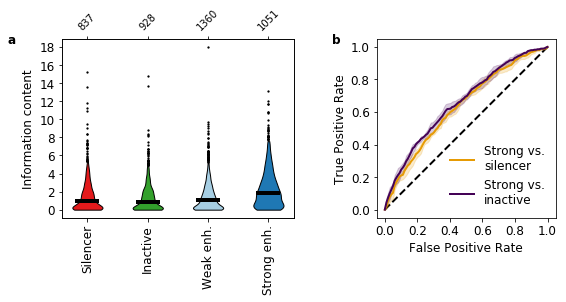

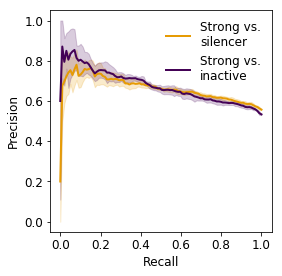

In [11]:
# Setup figures
fig, ax_list = plot_utils.setup_multiplot(2, sharex=False, sharey=False)
fig_pr, ax_pr = plt.subplots()

# 3a: violin plot of information content
print("Information content for each class:")
display(wt_entropy_grouper["entropy"].describe())

ax = ax_list[0]
fig = plot_utils.violin_plot_groupby(wt_entropy_grouper["entropy"], "Information content", class_names=wt_activity_names_oneline, class_colors=color_mapping, figax=(fig, ax))
plot_utils.rotate_ticks(ax.get_xticklabels())
ax.set_yticks(np.arange(0, wt_entropy_df["entropy"].max() + 1, 2))
plot_utils.add_letter(ax, -0.2, 1.03, "a")

# Add ticks above to show the n
ax_twin = ax.twiny()
ax_twin.set_xticks(ax.get_xticks())
ax_twin.set_xlim(ax.get_xlim())
ax_twin.set_xticklabels(wt_activity_count, fontsize=10, rotation=45)

# Statistics for differences in information content
ustat, pval = stats.mannwhitneyu(wt_entropy_grouper["entropy"].get_group("Strong enhancer"), wt_entropy_grouper["entropy"].get_group("Silencer"), alternative="two-sided")
print(f"Strong enhancers and silencers have the same information content, Mann-Whitney U test p = {pval:.0e} U = {ustat:.2f}")
ustat, pval = stats.mannwhitneyu(wt_entropy_grouper["entropy"].get_group("Strong enhancer"), wt_entropy_grouper["entropy"].get_group("Inactive"), alternative="two-sided")
print(f"Strong enhancers and inactive sequences have the same information content, Mann-Whitney U test p = {pval:.0e}, U = {ustat:.2f}")

# 3b: ROC and PR curves with information content vs. two classes
model_data = [
    (entropy_tpr_cv, entropy_prec_cv, "Strong vs.\nsilencer", "#E69B04"),
    (inactive_entropy_tpr_cv, inactive_entropy_prec_cv, "Strong vs.\ninactive", plot_utils.set_color(1))
]

model_tprs, model_precs, model_names, model_colors = zip(*model_data)
ax = ax_list[1]

# Plot the models
_, model_aurocs, model_aurocs_std, model_auprs, model_auprs_std = plot_utils.roc_pr_curves(
    modeling_xaxis, model_tprs, model_precs, model_names, model_colors=model_colors,
    figax=([fig, fig_pr], [ax, ax_pr])
)
ax.set_xticks(np.linspace(0, 1, 6))
plot_utils.add_letter(ax, -0.2, 1.03, "b")

# Display model metrics
print("Model metrics:")
for name, auroc, auroc_std, aupr, aupr_std in zip(model_names, model_aurocs, model_aurocs_std, model_auprs, model_auprs_std):
    print(f"{name}\tAUROC={auroc:.3f}+/-{auroc_std:.3f}\tAUPR={aupr:.3f}+/-{aupr_std:.3f}")
    
plot_utils.save_fig(fig, os.path.join(figures_dir, "figure3"), timestamp=False, tight_pad=0)
plot_utils.save_fig(fig_pr, os.path.join(figures_dir, "supplementalFigure6"), timestamp=False)

## Figure 4: Sequence features of autonomous and non-autonomous strong enhancers

Correlation between WT activity with Rho vs. Polylinker:
PCC = 0.338
SCC = 0.359
n = 4751
Fraction of autonomous sequences belonging to each activity class:


Strong enhancer    0.693103
Weak enhancer      0.208621
Inactive           0.070690
Silencer           0.027586
Name: group_name_WT, dtype: float64

Fraction of each activity class that has autonomous activity:


group_name_WT
Silencer           0.019394
Inactive           0.044565
Weak enhancer      0.090705
Strong enhancer    0.387657
Name: autonomous_activity, dtype: float64

Information content of autonomous and non-autonomous strong enhancers:


,count,mean,std,min,25%,50%,75%,max
autonomous_activity,,,,,,,,
False,635.0,2.073301,1.964160,0.000173,0.488725,1.624789,3.026204,11.747577
True,402.0,2.888074,2.424544,0.000346,0.990757,2.272392,4.401275,13.082139


Autonomous and non-autonomous strong enhancers have the same information content, Mann-Whitney U test p=4e-08, U=101739.00
Predicted CRX occupancy of autonomous and non-autonomous strong enhancers:


,count,mean,std,min,25%,50%,75%,max
autonomous_activity,,,,,,,,
False,635.0,2.34943,1.154518,0.003694,1.471752,2.255551,3.075332,7.368500
True,402.0,2.83343,1.127028,0.015596,2.062315,2.858271,3.554521,5.852791


Autonomous and non-autonomous strong enhancers have the same predicted CRX occupancy, Mann-Whitney U test p=9e-12, U=95541.00
Strong enhancers with autonomous and non-autonomous activity vs. NRL bound and unbound:


nrl_bound,False,True
autonomous_activity,,
False,513,122
True,236,166


Fisher's exact test that NRL binding and strong enhancer autonomous activity are independent, p=2e-14, odds ratio=3.0


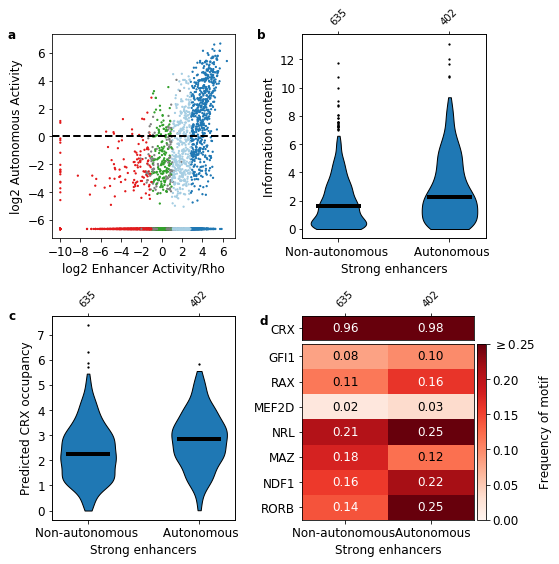

In [12]:
# Keep sequences where the WT and Polylinker were both measured
poly_measured_mask = activity_df[["expression_log2_WT", "expression_log2_POLY"]].notna().all(axis=1)
activity_poly_df = activity_df[poly_measured_mask]
wt_occupancy_poly_df = wt_occupancy_df[poly_measured_mask]
wt_entropy_poly_df = wt_entropy_df[poly_measured_mask]

# Setup the figure
fig, ax_list = plot_utils.setup_multiplot(4, sharex=False, sharey=False)
ax_list = ax_list.flatten()

# 4a: scatterplot of Rho vs. Polylinker
ax = ax_list[0]
print("Correlation between WT activity with Rho vs. Polylinker:")
fig, ax = plot_utils.scatter_with_corr(activity_poly_df["expression_log2_WT"], activity_poly_df["expression_log2_POLY"], "log2 Enhancer Activity/Rho", "log2 Autonomous Activity", colors=activity_poly_df["plot_color_WT"], xticks=rho_ticks, figax=(fig, ax))
ax.axhline(0, color="k", linestyle="--")
plot_utils.add_letter(ax, -0.2, 1.03, "a")

# Display some numbers for the manuscript
print("Fraction of autonomous sequences belonging to each activity class:")
display(activity_poly_df.loc[activity_poly_df["autonomous_activity"], "group_name_WT"].value_counts(normalize=True))

print("Fraction of each activity class that has autonomous activity:")
display(activity_poly_df.groupby("group_name_WT")["autonomous_activity"].apply(lambda x: x.sum() / len(x)))

# Information content of strong autonomous vs. non-autonomous
# Set up grouping
strong_enh_poly_mask = activity_poly_df["group_name_WT"].str.contains("Strong")
strong_enh_poly_mask = strong_enh_poly_mask & strong_enh_poly_mask.notna()
autonomous_occ_grouper = wt_occupancy_poly_df[strong_enh_poly_mask].groupby(activity_poly_df.loc[strong_enh_poly_mask, "autonomous_activity"])
autonomous_entropy_grouper = wt_entropy_poly_df[strong_enh_poly_mask].groupby(activity_poly_df.loc[strong_enh_poly_mask, "autonomous_activity"])

# Set up for plotting
strong_color = color_mapping["Strong enhancer"]
autonomous_names = ["Non-autonomous ", " Autonomous"]
autonomous_counts = [len(i) for i in autonomous_occ_grouper.groups.values()]

# Do stats for difference in IC
print("Information content of autonomous and non-autonomous strong enhancers:")
display(autonomous_entropy_grouper["entropy"].describe())
ustat, pval = stats.mannwhitneyu(*[j for i, j in autonomous_entropy_grouper["entropy"]], alternative="two-sided")
print(f"Autonomous and non-autonomous strong enhancers have the same information content, Mann-Whitney U test p={pval:.0e}, U={ustat:.2f}")

# 4b: Make the plot
ax = ax_list[1]
fig = plot_utils.violin_plot_groupby(autonomous_entropy_grouper["entropy"], "Information content", class_names=autonomous_names, class_colors=[strong_color]*2, figax=(fig, ax))
ax.set_xlabel("Strong enhancers")
# Add ticks for the n
ax_twin = ax.twiny()
ax_twin.set_xticks(ax.get_xticks())
ax_twin.set_xlim(ax.get_xlim())
ax_twin.set_xticklabels(autonomous_counts, fontsize=10, rotation=45)
plot_utils.add_letter(ax, -0.2, 1.03, "b")

# Differences in CRX occupancy
print("Predicted CRX occupancy of autonomous and non-autonomous strong enhancers:")
display(autonomous_occ_grouper["CRX"].describe())
ustat, pval = stats.mannwhitneyu(*[j for i, j in autonomous_occ_grouper["CRX"]], alternative="two-sided")
print(f"Autonomous and non-autonomous strong enhancers have the same predicted CRX occupancy, Mann-Whitney U test p={pval:.0e}, U={ustat:.2f}")

# 4c
ax = ax_list[2]
fig = plot_utils.violin_plot_groupby(autonomous_occ_grouper["CRX"], "Predicted CRX occupancy", class_names=autonomous_names, class_colors=[strong_color]*2, figax=(fig, ax))
ax.set_xlabel("Strong enhancers")
ax.set_yticks(np.arange(8))
# Add ticks for the n
ax_twin = ax.twiny()
ax_twin.set_xticks(ax.get_xticks())
ax_twin.set_xlim(ax.get_xlim())
ax_twin.set_xticklabels(autonomous_counts, fontsize=10, rotation=45)
plot_utils.add_letter(ax, -0.2, 1.03, "c")

# Differences in motif frequencies
autonomous_motif_freq_df = autonomous_occ_grouper.apply(lambda x: (x > occupied_cutoff).sum() / len(x))
# Sort by the feature importance in the logistic model
autonomous_motif_freq_df = autonomous_motif_freq_df.iloc[:, feature_order]

# 4d: Make heatmakt, but put CRX separate
ax = ax_list[3]
autonomous_motif_freq_no_crx_df = autonomous_motif_freq_df.drop(columns="CRX") 
vmax = 0.25
thresh = vmax / 2
heatmap = ax.imshow(autonomous_motif_freq_no_crx_df.T, aspect="auto", cmap="Reds", vmax=vmax, vmin=0)
ax.set_xlabel("Strong enhancers")
ax.set_xticks(np.arange(len(autonomous_motif_freq_no_crx_df)))
ax.set_xticklabels(autonomous_names)
ax.set_yticks(np.arange(len(autonomous_motif_freq_no_crx_df.columns)))
ax.set_yticklabels(autonomous_motif_freq_no_crx_df.columns)
plot_utils.annotate_heatmap(ax, autonomous_motif_freq_no_crx_df, thresh)

# Add colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad="2%")
colorbar = fig.colorbar(heatmap, cax=cax, label="Frequency of motif")
ticks = cax.get_yticks()
ticks = [f"{i:.2f}" for i in ticks]
ticks[-1] = r"$\geq$" + ticks[-1]
cax.set_yticklabels(ticks)

# Add CRX
cax = divider.append_axes("top", size="14%", pad="2%")
heatmap = cax.imshow(autonomous_motif_freq_df["CRX"].to_frame().T, aspect="auto", cmap="Reds", vmax=vmax, vmin=0)
cax.set_xticks([])
cax.set_yticks([0])
cax.set_yticklabels(["CRX"])
plot_utils.annotate_heatmap(cax, autonomous_motif_freq_df["CRX"].to_frame(), thresh)
plot_utils.add_letter(cax, -0.2, 1.03, "d")

# Add ticks for the n
cax.xaxis.tick_top()
cax.set_xticks(ax.get_xticks())
cax.set_xlim(ax.get_xlim())
cax.set_xticklabels(autonomous_counts, fontsize=10, rotation=45)

# Test relationship between NRL binding and strong enhancer autonomous activity
print("Strong enhancers with autonomous and non-autonomous activity vs. NRL bound and unbound:")
nrl_chip_vs_autonomous = activity_poly_df[strong_enh_poly_mask].groupby("autonomous_activity")["nrl_bound"].value_counts().unstack()
display(nrl_chip_vs_autonomous)
oddsratio, pval = stats.fisher_exact(nrl_chip_vs_autonomous)
print(f"Fisher's exact test that NRL binding and strong enhancer autonomous activity are independent, p={pval:.0e}, odds ratio={oddsratio:.1f}")

plot_utils.save_fig(fig, os.path.join(figures_dir, "figure4"), timestamp=False)

## Figure 5: Independence of TF motifs in strong enhancers

In [13]:
# Helper functions to visualize sequence
def hex_to_rgb(hexcode):
    return tuple(int(hexcode[i:i+2], 16) / 255 for i in (1, 3, 5))

strong_color_rgb = hex_to_rgb(strong_color)
weak_color_rgb = hex_to_rgb(color_mapping["Weak enhancer"])
crx_color = mpl.colors.to_rgb("orange")
other_tf_color = mpl.colors.to_rgb("red")

def visualize_sequence(seq_id, ax, title, below_text, basecolor):
    seq_occupancy_df = predicted_occupancy.total_landscape(all_seqs[seq_id], ewms, mu)
    visual = np.full(((len(seq_occupancy_df), 3)), basecolor) # (number of positions, RGB values)
    text_mapping = [] # (name of TF, center position of motif)
    # Loop over each TF, identify motifs, and fill in the representation with the predicted occupancy for the full motif
    for col in seq_occupancy_df:
        tf, orient = col.split("_")
        for motif_start, occ in seq_occupancy_df[col].iteritems():
            if occ > occupied_cutoff:
                motif_end = motif_start + motif_len[tf]
                # Check and make sure all positions of the motif are zeros
                if (visual[motif_start:motif_end] != basecolor).all(axis=1).any():
                    print(f"Error, motif already in the range {motif_start}-{motif_end}! Skipping.")
                else:
                    color = crx_color if tf == "CRX" else other_tf_color
                    visual[motif_start:motif_end] = color
                    text_mapping.append((tf, (motif_start + motif_end) / 2))
        
    heatmap = ax.imshow(visual[np.newaxis, :], aspect="auto", cmap="Reds")
    ax.set_yticks([])
    # Add text showing which motif is where
    for tf, x in text_mapping:
        ax.text(x, 0, tf, ha="center", va="center", color="white", rotation=90)

    ax.set_title(title)
    ax.set_xlabel(below_text)
    
    return ax, heatmap

Correlation between WT and MUT activities:
PCC = 0.608
SCC = 0.706
n = 4123
Information content of strong enhancers with different mutant activities:


,count,mean,std,min,25%,50%,75%,max
group_name_MUT,,,,,,,,
False,586.0,2.321663,2.067846,0.000346,0.641760,1.849581,3.333561,11.676515
True,344.0,2.857066,2.411316,0.001591,1.145032,2.413095,3.969305,13.082139


Predicted CRX occupancy of strong enhancers with different mutant activities:


,count,mean,std,min,25%,50%,75%,max
group_name_MUT,,,,,,,,
False,586.0,2.876820,1.069855,0.927761,2.085474,2.857976,3.575210,7.368500
True,344.0,2.454016,1.009155,0.964684,1.626097,2.338718,3.110073,5.730406


Strong enhancers that remain strong vs. do not have the same CRX occupancy, Mann-Whitney U test p=2e-09, U=124411.00
Residual information content of strong enhancers with different mutant activities:


,count,mean,std,min,25%,50%,75%,max
group_name_MUT,,,,,,,,
False,586.0,1.026129,1.283253,0.000001,0.097540,0.493644,1.472322,7.129248
True,344.0,1.536551,1.638575,0.000136,0.264872,1.046836,2.338690,9.819172


Strong enhancers that stay strong vs. do not have the same residual information content, Mann-Whitney U test p=1e-07, U=79938.00


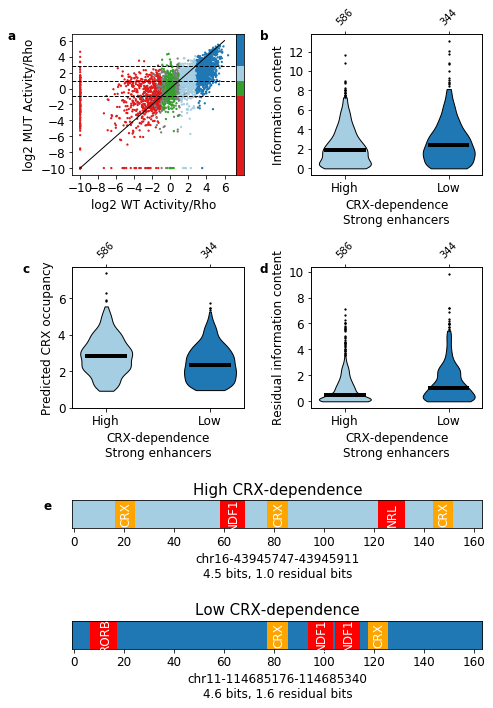

In [14]:
# Setup for sequences where both WT and MUT was measured
wt_mut_mask = activity_df["wt_vs_mut_log2"].notna()
activity_wt_mut_measured_df = activity_df[wt_mut_mask]
wt_occ_mut_measured_df = wt_occupancy_df[wt_mut_mask]
wt_entropy_mut_measured_df = wt_entropy_df[wt_mut_mask]
mut_entropy_measured_df = mut_entropy_df[wt_mut_mask]

# Figure setup
gs_kw = dict(height_ratios=[5, 5, 1, 1])
fig, ax_list = plt.subplots(nrows=4, ncols=2, figsize=(7, 10), gridspec_kw=gs_kw)
gs = ax_list[0, 0].get_gridspec()
for row in [2, 3]:
    for ax in ax_list[row]:
        ax.remove()
    
axstrong = fig.add_subplot(gs[2, :])
axweak = fig.add_subplot(gs[3, :])

# 5a: Scatter plot of WT and MUT activities
ax = ax_list[0, 0]
print("Correlation between WT and MUT activities:")
fig, ax = plot_utils.scatter_with_corr(activity_wt_mut_measured_df["expression_log2_WT"], activity_wt_mut_measured_df["expression_log2_MUT"],
                                      "log2 WT Activity/Rho", "log2 MUT Activity/Rho", colors=activity_wt_mut_measured_df["plot_color_WT"],
                                      xticks=rho_ticks, yticks=rho_ticks, figax=(fig, ax))
# Plot y = x line
ax.plot(rho_ticks, rho_ticks, color="black", linewidth=1)
# Show cutoffs for different classes
strong_cutoff = activity_df.groupby("group_name_WT")["expression_log2_WT"].get_group("Strong enhancer").min()
for line in [-1, 1, strong_cutoff]:
    ax.axhline(line, color="black", linestyle="--", linewidth=1)
    
# Add colorbar to show the cutoffs
divider = make_axes_locatable(ax)
color_ax = divider.append_axes("right", size="5%")
color_ax.set_ylim(ax.get_ylim())
color_ax.barh([(-1 - ax.get_ylim()[0]) / 2 + ax.get_ylim()[0], 0, (strong_cutoff - 1) / 2 + 1, (ax.get_ylim()[1] - strong_cutoff) / 2 + strong_cutoff], # Midpoint of the bars
             [1, 1, 1, 1], # Bar height
             [-1 - ax.get_ylim()[0], 2, strong_cutoff - 1, ax.get_ylim()[1] - strong_cutoff], # Bar width
             color=color_mapping)
color_ax.set_xticks([])
color_ax.set_yticks([])
color_ax.set_xlim(right=1)

plot_utils.add_letter(ax, -0.35, 1.03, "a")

# Setup strong enhancer->mutant activity groupings
strong_mask = activity_wt_mut_measured_df["group_name_WT"].str.contains("Strong")
strong_mask = strong_mask & strong_mask.notna()
activity_strong_df = activity_wt_mut_measured_df[strong_mask]

# Group the data based on CRX-dependence (whether or not it stay strong) and name the groups accordingly
stay_strong_mask = activity_strong_df["group_name_MUT"].str.contains("Strong") & activity_strong_df["group_name_MUT"].notna()
wt_occ_strong_grouper = wt_occ_mut_measured_df[strong_mask].groupby(stay_strong_mask)
wt_entropy_strong_grouper = wt_entropy_mut_measured_df[strong_mask].groupby(stay_strong_mask)
strong_mutant_names = wt_entropy_strong_grouper["entropy"].count().rename({False: "High", True: "Low"}).index.values.tolist()
strong_mutant_counts = wt_entropy_strong_grouper["entropy"].count().astype(int).values

# Differences in information content
print("Information content of strong enhancers with different mutant activities:")
display(wt_entropy_strong_grouper["entropy"].describe())

# 5b: Information content
ax = ax_list[0, 1]
fig = plot_utils.violin_plot_groupby(wt_entropy_strong_grouper["entropy"], "Information content", class_names=strong_mutant_names, class_colors=color_mapping[["Weak enhancer", "Strong enhancer"]], figax=(fig, ax))
ax.set_xlabel("CRX-dependence\nStrong enhancers")
ax.set_yticks(np.arange(0, 13, 2))
ax_twin = ax.twiny()
ax_twin.set_xticks(ax.get_xticks())
ax_twin.set_xlim(ax.get_xlim())
ax_twin.set_xticklabels(strong_mutant_counts, fontsize=10, rotation=45)
plot_utils.add_letter(ax, -0.25, 1.03, "b")

# Differences in predicted CRX occupancy of strong enhancers with different CRX-dependences
print("Predicted CRX occupancy of strong enhancers with different mutant activities:")
display(wt_occ_strong_grouper["CRX"].describe())
ustat, pval = stats.mannwhitneyu(*[j for i, j in wt_occ_strong_grouper["CRX"]], alternative="two-sided")
print(f"Strong enhancers that remain strong vs. do not have the same CRX occupancy, Mann-Whitney U test p={pval:.0e}, U={ustat:.2f}")

# 5c: predicted CRX occupancy
ax = ax_list[1, 0]
fig = plot_utils.violin_plot_groupby(wt_occ_strong_grouper["CRX"], "Predicted CRX occupancy", class_names=strong_mutant_names, class_colors=color_mapping[["Weak enhancer", "Strong enhancer"]], figax=(fig, ax))
ax.set_xlabel("CRX-dependence\nStrong enhancers")
ax.set_yticks(np.arange(0, 8, 2))
ax_twin = ax.twiny()
ax_twin.set_xticks(ax.get_xticks())
ax_twin.set_xlim(ax.get_xlim())
ax_twin.set_xticklabels(strong_mutant_counts, fontsize=10, rotation=45)
plot_utils.add_letter(ax, -0.25, 1.03, "c")

# Differences in redisual IC
print("Residual information content of strong enhancers with different mutant activities:")
mut_entropy_strong_grouper = mut_entropy_measured_df[strong_mask].groupby(stay_strong_mask)
display(mut_entropy_strong_grouper["entropy"].describe())
ustat, pval = stats.mannwhitneyu(*[j for i, j in mut_entropy_strong_grouper["entropy"]], alternative="two-sided")
print(f"Strong enhancers that stay strong vs. do not have the same residual information content, Mann-Whitney U test p={pval:.0e}, U={ustat:.2f}")

# 5d: Residual information content
ax = ax_list[1, 1]
fig = plot_utils.violin_plot_groupby(mut_entropy_strong_grouper["entropy"], "Residual information content", class_names=strong_mutant_names, class_colors=color_mapping[["Weak enhancer", "Strong enhancer"]], figax=(fig, ax))
ax.set_xlabel("CRX-dependence\nStrong enhancers")
ax.set_yticks(np.arange(0, 11, 2))
ax_twin = ax.twiny()
ax_twin.set_xticks(ax.get_xticks())
ax_twin.set_xlim(ax.get_xlim())
ax_twin.set_xticklabels(strong_mutant_counts, fontsize=10, rotation=45)
plot_utils.add_letter(ax, -0.25, 1.03, "d")

# 5e Visualize the two depresentative sequences
ax = axstrong
become_weak_example_id = "chr16-43945747-43945911_UPPE"
become_weak_text = become_weak_example_id.split("_")[0] + "\n" + f"{wt_entropy_df.loc[become_weak_example_id, 'entropy']:.1f}" + " bits, " + f"{mut_entropy_df.loc[become_weak_example_id, 'entropy']:.1f}" + " residual bits"
ax, become_weak_visual = visualize_sequence(become_weak_example_id + "_WT", ax, "High CRX-dependence", become_weak_text, weak_color_rgb)
plot_utils.add_letter(ax, -0.05, 1.03, "e")

ax = axweak
stay_strong_example_id = "chr11-114685176-114685340_CPPE"
stay_strong_text = stay_strong_example_id.split("_")[0] + "\n" + f"{wt_entropy_df.loc[stay_strong_example_id, 'entropy']:.1f}" + " bits, " + f"{mut_entropy_df.loc[stay_strong_example_id, 'entropy']:.1f}" + " residual bits"
ax, stay_strong_visual = visualize_sequence(stay_strong_example_id + "_WT", ax, "Low CRX-dependence", stay_strong_text, strong_color_rgb)

plot_utils.save_fig(fig, os.path.join(figures_dir, "figure5"), timestamp=False)